In [134]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

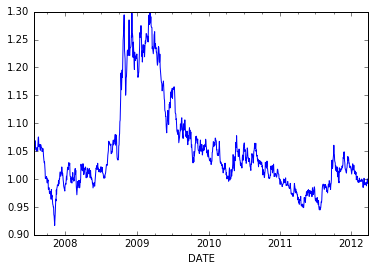

In [280]:
start=datetime.datetime(2007,7,22)
end=datetime.datetime(2012,3,28)
y=web.DataReader("DEXCAUS",'fred', start,end)
y=y['DEXCAUS']
y=y.interpolate()
y.plot()

In [281]:
ts.adfuller(y, maxlag=1,regression='c')

(-1.8511716900269124,
 0.35536828691259603,
 0L,
 1222L,
 {'1%': -3.4357125938551909,
  '10%': -2.5680308008925294,
  '5%': -2.8639080782530031},
 -8119.4896879147927)

Hurst

In [282]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract,square,dot
from numpy.random import randn

def normcdf(X):
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / sqrt(2*pi)*exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    if X<0:
        w = 1.0-w
    return w

def vratio(a, lag = 2, cor = 'hom'):
    t = (std((a[lag:]) - (a[1:-lag+1])))**2;
    b = (std((a[2:]) - (a[1:-1]) ))**2;
 
    n = float(len(a))
    mu  = sum(a[1:n]-a[:-1])/n;
    m=(n-lag+1)*(1-lag/n);
#   print mu, m, lag
    b=sum(square(a[1:n]-a[:n-1]-mu))/(n-1)
    t=sum(square(a[lag:n]-a[:n-lag]-lag*mu))/m
    vratio = t/(lag*b);
 
    la = float(lag)
     
 
    if cor == 'hom':
        varvrt=2*(2*la-1)*(la-1)/(3*la*n)
 
 
    elif cor == 'het':
          varvrt=0;
          sum2=sum(square(a[1:n]-a[:n-1]-mu)); 
          for j in range(lag-1):
             sum1a=square(a[j+1:n]-a[j:n-1]-mu); 
             sum1b=square(a[1:n-j]-a[0:n-j-1]-mu)
             sum1=dot(sum1a,sum1b); 
             delta=sum1/(sum2**2);
             varvrt=varvrt+((2*(la-j)/la)**2)*delta
 
    zscore = (vratio - 1) / sqrt(float(varvrt))
    pval = normcdf(zscore);
 
    return  vratio, zscore, pval

def hurst(ts):
	"""Returns the Hurst Exponent of the time series vector ts"""
	# Create the range of lag values
	lags = range(1,20)

	# Calculate the array of the variances of the lagged differences
	tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

	# Use a linear fit to estimate the Hurst Exponent
	poly = polyfit(log(lags), log(tau), 1)

	# Return the Hurst exponent from the polyfit output
	return poly[0]*2.0
hurst(y)

0.47205967055713893

In [283]:
vratio(np.log(y.tolist()), cor = 'het', lag = 20)

C:\Users\Roger\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Roger\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Roger\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Roger\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Roger\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Roger\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecati

(0.90887939415028185, -0.37098253268536285, 0.35532532609940382)

Half-life

In [284]:
y_lag=np.roll(y,1)
y_delta=y-y_lag
y_delta[0]=np.NaN
y_lag[0]=np.NaN
y_lag2 = sm.add_constant(y_lag)
y_lag

array([    nan,  1.045 ,  1.0372, ...,  0.9983,  0.9922,  0.9928])

In [285]:
results=smf.ols('y_delta~y_lag',{'y_lag':y_lag2,'y_delta':y_delta}).fit()
results.params

Intercept    0.003004
y_lag[0]     0.003004
y_lag[1]    -0.005763
dtype: float64

In [286]:
halflife=-np.log(2)/results.params[2]
halflife

120.2830502183437

First mean reversion strategy  
halflife=lookback (or multiple)

In [287]:
def movingAvg(x,N=20):
    return np.insert(np.convolve(x,np.ones(N)/N, mode='valid'),0,[0]*(N-1))
def rolling_window(a, window):
    a=np.insert(np.array(a),0,[0]*(window-1))
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    arr=np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return arr

C:\Users\Roger\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Roger\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


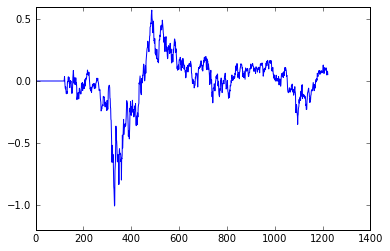

In [288]:
lookback=np.round(halflife)
windowed=rolling_window(y,lookback)
mktVal=np.array(-(y-movingAvg(y,lookback))/np.std(windowed))
mktVal[:lookback]=0
plt.plot(mktVal)

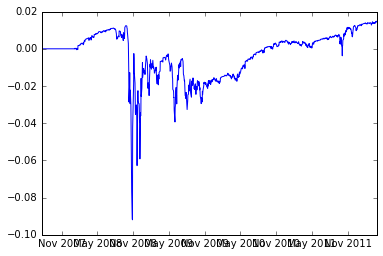

In [289]:
mktLag=np.roll(mktVal,1)
mktLag[0]=0
pnl=mktLag*(y_delta)/y_lag
plt.plot(np.cumsum(pnl))